# CLUSTERING

## Import Library

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler # Skala menjadi 0-1
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
plt.style.use('fivethirtyeight')

Import library dalam regresi linear berguna untuk mempermudah proses analisis dan pembuatan model yang efektif.

## Load Dataset

In [29]:
data = pd.read_csv('/content/Dataset-Tugas.csv')
data

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Membaca dataset yang akan digunakan untuk regresi analysis. Dataset ini berisi data mengenai karakteristik tiga spesies bunga iris yaitu, Iris setosa, Iris versicolor, dan Iris virginica.

## EDA

In [30]:
data.shape

(150, 5)

Mengecek dimensi dari dataset. Terdapat sebanyak 150 baris dan 5 kolom dalam dataset iris ini.

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Mengecek informasi dari data. Ada 2 macam tipe data dalam dataset iris, float dan object. Secara keseluruhan, tidak ada data yang kosong (null).

In [32]:
data.isnull().sum()

,0
sepal length,0
sepal width,0
petal length,0
petal width,0
class,0


Mengecek data kosong / missing value. Dari 5 kolom yang ada, tidak ditemukan satupun missing value, sehingga dataset ini termasuk bersih.

In [33]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petal length,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petal width,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


Mengecek statistika deskriptif dari dataset untuk kolom selain object seperti nilai mean, standar deviasi, minimum, maximum, Q1, Q2, dan Q3.

In [34]:
data.describe(include=['object'])

,class
count,150
unique,3
top,Iris-setosa
freq,50


Mengecek statistika deskriptif dari dataset untuk kolom selain object seperti jumlah data, nilai unique, top, dan frequency. Dari output ini, diketahui untuk kolom `class` yang bertipe data object memiliki jumlah data sebanyak 150, nilai unique sebanyak 3 (Iris setosa, Iris versicolor, dan Iris virginica), nilai yang paling sering muncul berupa Iris setosa, dan frekuensi dari top sebanyak 50.

In [35]:
data.drop(columns='class', inplace=True)

Melakukan drop kolom `class` karena dalam proses clustering harus bersifat **unsupervised learning** yang bertujuan untuk menemukan pola atau kelompok dalam data tanpa menggunakan label atau target. Kolom `class` sendiri berisi label yang menunjukkan spesies bunga. Sehingga jika kolom `class` tidak dihapus (drop) maka akan melanggar sifat unsupervised learning, karena algoritma akan diberi tahu label sebenarnya dan akan membuat hasil clustering menjadi tidak valid.

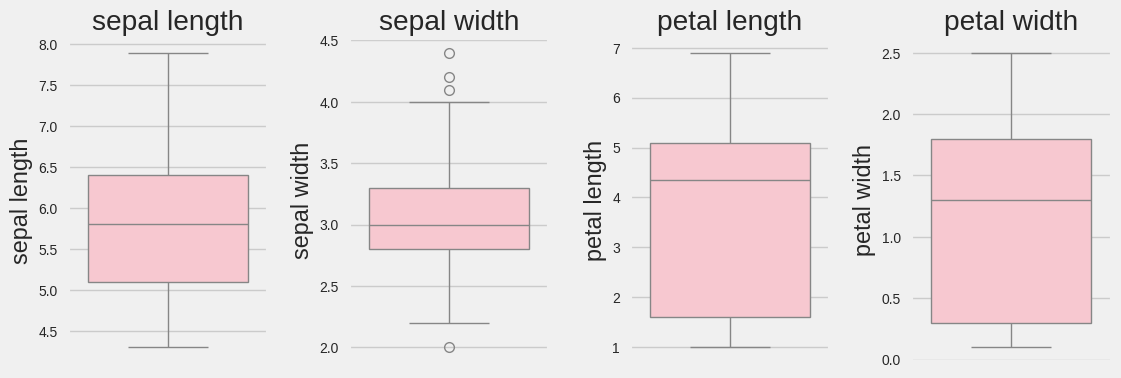

In [36]:
def box_plot(data):
  # Definisikan variabel yang akan divisualisasikan
  variables = data.select_dtypes(exclude = 'object').columns

  # Buat figure dan axes untuk subplot dengan ukuran 1x3
  fig, axes = plt.subplots(1, 4, figsize = (12, 4)) # Sesuaikan ukuran figure
  fig.subplots_adjust(hspace = 0.4, wspace = 0.4) # Atur jarak antar subplot

  # Iterasi melalui setiap variabel dan buat boxplot
  for i, var in enumerate(variables):
    sns.boxplot(y=var, data=data, color = "pink", ax=axes[i]) # Perhatikan perubahan di sini
    axes[i].set_title(var) # Tambahkan judul untuk setiap plot

  # Tampilkan plot
  plt.show()

# Panggil fungsi box_plot dengan data yang sesuai
box_plot(data)

Visualisasi boxplot digunakan untuk membantu dalam memahami distribusi data.

In [37]:
# Inisiasi
scaler = MinMaxScaler()

# Fit_transform
X_scaled = scaler.fit_transform(data)
X_scaled

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

Mengubah rentang data menjadi 0 sampai 1 agar hasil model yang didapatkan lebih proporsonal.

## Modelling

### K-Means

K-means adalah algoritma clustering yang digunakan untuk mengelompokkan data ke dalam sejumlah cluster berdasarkan kemiripan fitur. Tujuan utama dari K-means adalah untuk meminimalkan jarak antara titik data dalam satu cluster dengan centroid cluster tersebut.

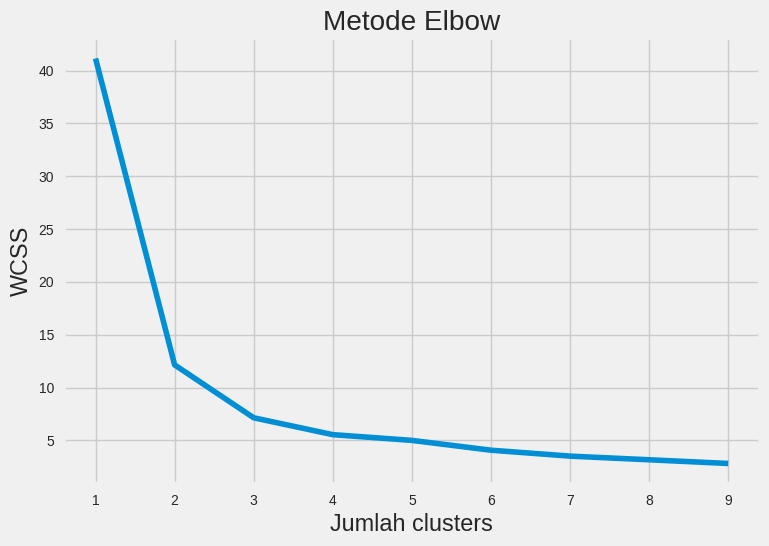

In [38]:
# Menggunakan metode elbow untuk menentukan angka cluster yang tepat
wcss = []
for i in range(1, 10):
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Metode Elbow')
plt.xlabel('Jumlah clusters')
plt.ylabel('WCSS')
plt.show()

# Plot grafik Elbow

Elbow Method adalah salah satu teknik yang digunakan untuk menentukan jumlah cluster optimal dalam algoritma K-means. Tujuan utama dari metode ini adalah untuk membantu memilih jumlah cluster (k) yang dapat memberikan keseimbangan terbaik antara inertia (within-cluster sum of squares) dan jumlah cluster yang digunakan.

Dalam output di atas, penentuan jumlah cluster didasarkan dari angle yang berubah, yaitu pada posisi 2 dan 3. Sehingga dalam analisis K-Means ini akan dilakukan perbandingan antara model dengan 2 cluster dan 3 cluster.

Model 1 K-Means dengan 2 cluster

In [39]:
# Menjalankan K-Means Clustering ke Dataset
model1 = KMeans(n_clusters=2, init='k-means++', random_state=42)
y_pred1 = model1.fit_predict(X_scaled)

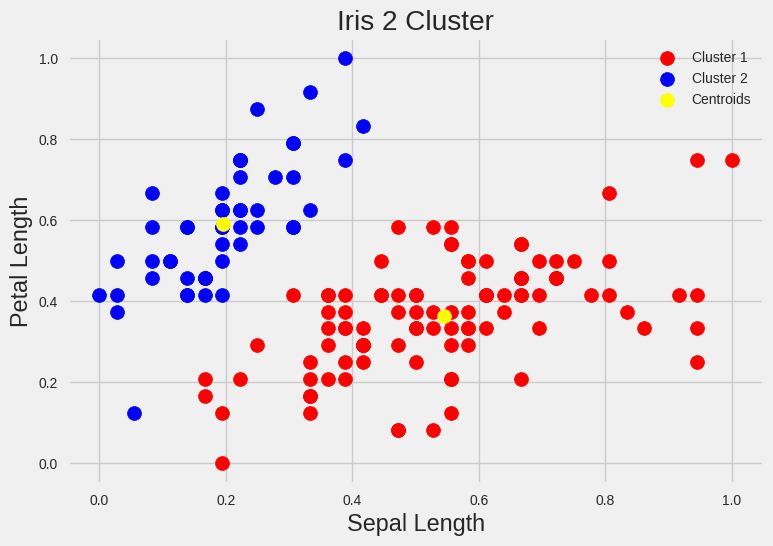

In [40]:
# Visualisasi hasil clusters (2 cluster)
plt.scatter(X_scaled[y_pred1 == 0, 0], X_scaled[y_pred1 == 0, 1], s = 100, c = 'red', label = 'Cluster 1')

plt.scatter(X_scaled[y_pred1 == 1, 0], X_scaled[y_pred1 == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(model1.cluster_centers_[:, 0], model1.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title('Iris 2 Cluster')
plt.xlabel('Sepal Length')
plt.ylabel('Petal Length')
plt.legend()
plt.show()

In [41]:
# Tambahkan label tersebut menjadi kolom baru di dataset
data['Hasil Cluster K-Means (2 Cluster)'] = model1.labels_
data.head()

,sepal length,sepal width,petal length,petal width,Hasil Cluster K-Means (2 Cluster)
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


Model 1 K-Means dengan 3 cluster

In [42]:
# Menjalankan K-Means Clustering ke Dataset
model2 = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_pred2 = model2.fit_predict(X_scaled)

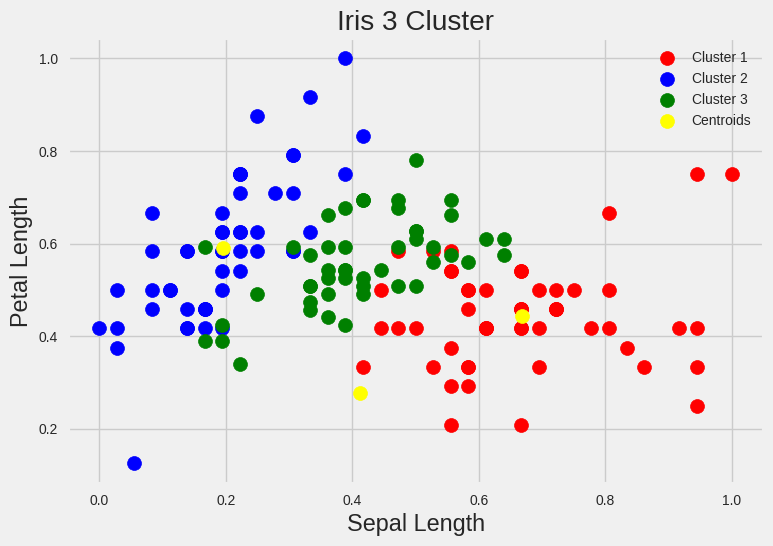

In [43]:
# Visualisasi hasil clusters (3 cluster)
plt.scatter(X_scaled[y_pred2 == 0, 0], X_scaled[y_pred2 == 0, 1], s = 100, c = 'red', label = 'Cluster 1')

plt.scatter(X_scaled[y_pred2 == 1, 0], X_scaled[y_pred2 == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(X_scaled[y_pred2 == 2, 0], X_scaled[y_pred2 == 2, 2], s = 100, c = 'green', label = 'Cluster 3')

plt.scatter(model2.cluster_centers_[:, 0], model2.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title('Iris 3 Cluster')
plt.xlabel('Sepal Length')
plt.ylabel('Petal Length')
plt.legend()
plt.show()

In [44]:
# Tambahkan label tersebut menjadi kolom baru di dataset
data['Hasil Cluster K-Means (3 Cluster)'] = model2.labels_
data.head()

,sepal length,sepal width,petal length,petal width,Hasil Cluster K-Means (2 Cluster),Hasil Cluster K-Means (3 Cluster)
0,5.1,3.5,1.4,0.2,1,1
1,4.9,3.0,1.4,0.2,1,1
2,4.7,3.2,1.3,0.2,1,1
3,4.6,3.1,1.5,0.2,1,1
4,5.0,3.6,1.4,0.2,1,1


### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) adalah algoritma clustering yang mengelompokkan data berdasarkan kepadatan titik di ruang fitur. Berbeda dengan algoritma K-means, algoritma DBSCAN tidak memerlukan jumlah cluster k yang ditentukan di awal, dan dapat mengenali cluster dengan bentuk yang tidak beraturan.

In [45]:
# Membuat objek  DBSCAN dengan parameter epsilon dan jumlah minimum sampel
model3 = DBSCAN(eps=0.37, min_samples=5) # besar kecilnya lingkaran berdasarkan nilai eps (hyperparameter bisa diubah2)

# Melakukan clustering
model3.fit(X_scaled)

# Mendapatkan label untuk setiap data (-1 menandakan noise)
y_pred3 = model3.labels_
y_pred3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Dari output tersebut, dapat diketahui hasil dari clustering menggunakan DBSCAN menghasilkan 2 kelompok/cluster utama. Nilai `0` menunjukkan bahwa data pada indeks-indeks yang sesuai termasuk ke dalam cluster pertama. Sedangkan nilai `1` menunjukkan bahwa data termasuk ke dalam cluster kedua. Dari hasil tersebut juga tidak menunjukkan label -1, yang berarti tidak ada data outlier yang masuk ke dalam cluster.

In [46]:
# Tambahkan label tersebut menjadi kolom baru di dataset
data['Hasil Cluster DBSCAN'] = model3.labels_
data.head()

,sepal length,sepal width,petal length,petal width,Hasil Cluster K-Means (2 Cluster),Hasil Cluster K-Means (3 Cluster),Hasil Cluster DBSCAN
0,5.1,3.5,1.4,0.2,1,1,0
1,4.9,3.0,1.4,0.2,1,1,0
2,4.7,3.2,1.3,0.2,1,1,0
3,4.6,3.1,1.5,0.2,1,1,0
4,5.0,3.6,1.4,0.2,1,1,0


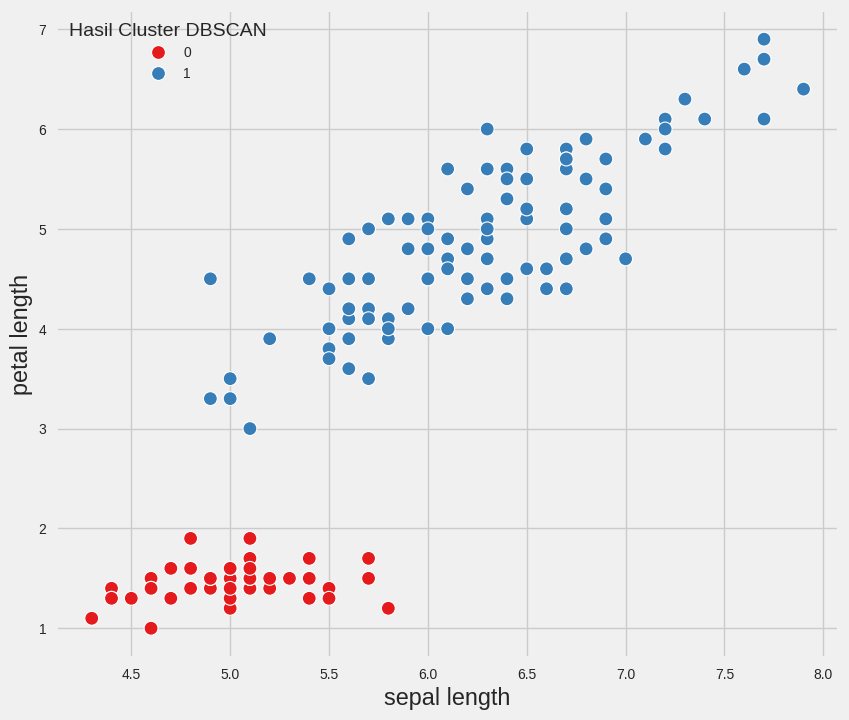

In [48]:
# Visualisasi

plt.figure(figsize=(9, 8))
sns.scatterplot(x = 'sepal length', y = 'petal length', hue = 'Hasil Cluster DBSCAN', data = data, palette = 'Set1', s=100);

## Evaluation Metrics

### K-Means

In [49]:
# Menghitung Silhouette Score Algoritma K-Means
Evaluasi_Kmeans = silhouette_score(X_scaled, y_pred1)
# Menghitung Davies-Bouldin Index (DBI) Algoritma K-Means
dbi_score1 = davies_bouldin_score(X_scaled, y_pred1)

print('Silhouette Score 2 Cluster:', Evaluasi_Kmeans)
print('Davies-Bouldin Index 2 Cluster:', dbi_score1)

Silhouette Score 2 Cluster: 0.6294675561906644
Davies-Bouldin Index 2 Cluster: 0.48770481288357487


Evaluation Metrics 2 Cluster

- Silhouette Score yang dihasilkan adalah 0.629. Nilai ini tergolong cukup tinggi (mendekati 1), yang menandakan bahwa titik-titik data dalam cluster lebih dekat dengan sesama anggota cluster nya dibandingkan dengan titik-titik dalam cluster lain. Sehingga, cluster yang terbentuk cukup "rapat" dan memiliki pemisahan yang baik dari cluster lainnya.
- Nilai Davies-Bouldin Index yang didapat sebesar 0.488, nilai ini relatif rendah. Semakin kecil nilai DBI, maka semakin baik kualitas clustering. Dengan nilai Davies-Bouldin Indexdi yang di bawah 1 ini, mengindikasikan bahwa cluster yang dihasilkan dari algoritma K-Means memiliki pemisahan yang cukup baik dan tidak terlalu tumpang tindih antar cluster.

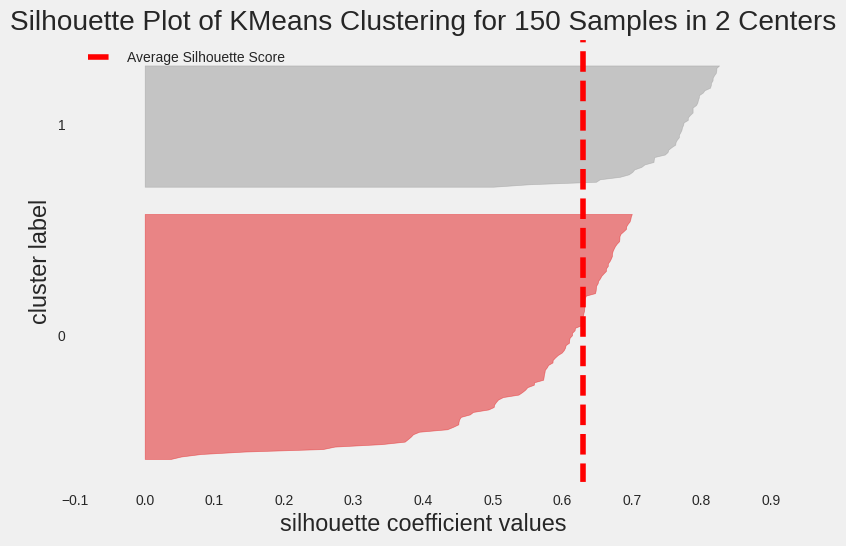

In [50]:
# Membuat Silhouette Visualization untuk Algoritma K-Means
silhouette_viz = SilhouetteVisualizer(model1)
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()

Visualisasi Silhouette Score tersebut mengevaluasi kualitas clustering hasil dari algoritma K-Means dengan dua cluster, yaitu cluster 0 (merah) dan cluster 1 (abu-abu). Sumbu x menunjukkan nilai koefisien silhouette, di mana nilai mendekati +1 menunjukkan bahwa sampel berada dalam cluster yang tepat, nilai mendekati 0 menunjukkan sampel di perbatasan antar cluster, dan nilai negatif menunjukkan kemungkinan penempatan sampel di cluster yang salah.

Garis merah putus-putus adalah rata-rata skor silhouette yang berada di sekitar 0.6, yang menunjukkan bahwa pemisahan antar cluster cukup baik, tapi belum sepenuhnya ideal. Mayoritas sampel berada dalam cluster yang tepat, tetapi beberapa sampel di cluster 0 memiliki nilai koefisien yang lebih rendah, yang berarti sebagian sampel berada di perbatasan antar cluster atau kurang cocok dalam cluster tersebut. Sementara itu, cluster 1 memiliki distribusi koefisien silhouette yang lebih tinggi dan lebih konsisten. Secara keseluruhan, hasil clustering ini cukup baik, namun evaluasi lebih lanjut diperlukan agar hasil lebih optimal.

In [51]:
# Menghitung Silhouette Score Algoritma K-Means
Evaluasi_Kmeans2 = silhouette_score(X_scaled, y_pred2)
# Menghitung Davies-Bouldin Index (DBI) Algoritma K-Means
dbi_score2 = davies_bouldin_score(X_scaled, y_pred2)

print('Silhouette Score 3 Cluster:', Evaluasi_Kmeans2)
print('Davies-Bouldin Index 3 Cluster:', dbi_score2)

Silhouette Score 3 Cluster: 0.48247222154221125
Davies-Bouldin Index 3 Cluster: 0.7874978912757878


Evaluation Metrics 3 Cluster

- Nilai Silhouette Score yang didapat sebesar 0.6294. Silhouette Score berkisar dari -1 hingga 1, di mana nilai mendekati 1 menunjukkan bahwa sampel berada dalam cluster yang tepat dan jauh dari cluster lainnya. Dengan nilai sekitar 0.6294 ini, hasil clustering yang didapat sudah termasuk cukup baik.
- Nilai Davies-Bouldin Index yang didapat sebesar 0.4877. Metrik ini mengukur rata-rata kesamaan antara setiap cluster dengan cluster yang paling mirip, dan berkisar dari 0 hingga tak terhingga. Nilai DBI yang lebih rendah menunjukkan pemisahan cluster yang lebih baik, karena jarak antar cluster semakin jauh. Dengan DBI sebesar 0.4877, hasil clustering ini dapat dikategorikan cukup baik, karena nilai DBI yang rendah mengindikasikan bahwa setiap cluster memiliki jarak yang relatif besar dengan cluster lainnya.

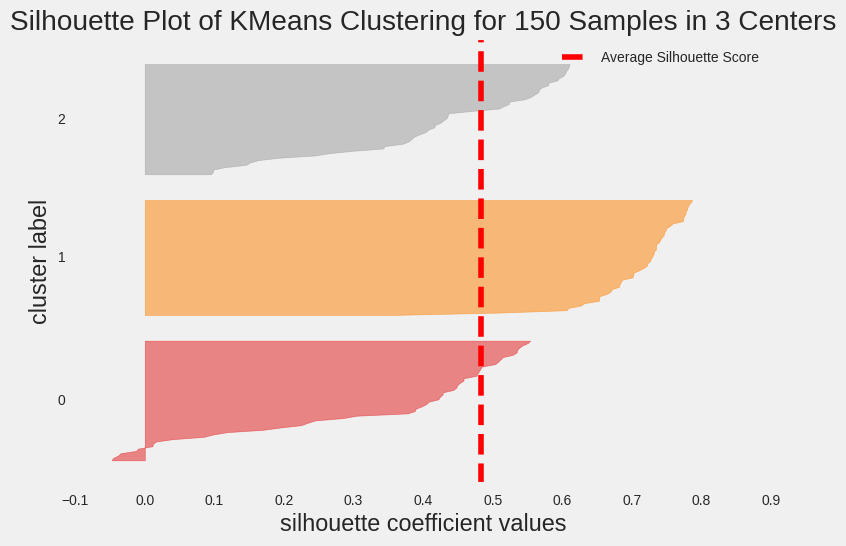

In [52]:
# Membuat Silhouette Visualization untuk Algoritma K-Means
silhouette_viz = SilhouetteVisualizer(model2)
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()

Visualisasi Silhouette Score tersebut mengevaluasi hasil clustering K-Means dengan tiga cluster (cluster 0, 1, dan 2) pada 150 sampel data. Sumbu x menunjukkan nilai koefisien silhouette, yang menilai seberapa baik setiap sampel cocok dengan cluster-nya, di mana nilai mendekati +1 menandakan pemisahan cluster yang baik, sementara nilai mendekati 0 menunjukkan sampel yang berada di perbatasan antar cluster, dan nilai negatif menunjukkan kemungkinan salah penempatan sampel dalam cluster.

Garis merah putus-putus menandakan rata-rata dari skor silhouette keseluruhan, yaitu berada di sekitar 0.5, yang menandakan cukup baik. Cluster 2 (abu-abu) memiliki distribusi koefisien silhouette yang tinggi dan konsisten, sehingga menunjukkan pemisahan cluster yang baik, sementara cluster 1 (oranye) menunjukkan kualitas yang serupa dengan beberapa sampel di perbatasan antar cluster. Cluster 0 (merah) memiliki distribusi yang lebih bervariasi, dengan beberapa sampel bernilai rendah atau negatif, sehingga menandakan kemungkinan ketidakcocokan beberapa sampel dalam cluster tersebut atau berada di perbatasan dengan cluster lain.

Secara keseluruhan, clustering ini cukup baik, meskipun cluster 0 menunjukkan adanya beberapa sampel yang tidak sepenuhnya sesuai dengan cluster-nya.

### DBSCAN

In [53]:
# Menghitung Silhouette Score Algoritma DBSCAN
Evaluasi_DBScan = silhouette_score(X_scaled, y_pred2)
# Menghitung Davies-Bouldin Index (DBI) Algoritma DBSCAN
dbi_score2 = davies_bouldin_score(X_scaled, y_pred2)

print('Silhouette Score:', Evaluasi_DBScan)
print('Davies-Bouldin Index:', dbi_score2)

Silhouette Score: 0.48247222154221125
Davies-Bouldin Index: 0.7874978912757878


- Nilai Silhouette Score sebesar 0.6294 menunjukkan bahwa model DBSCAN berhasil membentuk cluster yang cukup baik. Nilai ini berkisar antara -1 hingga 1, di mana nilai mendekati 1 menunjukkan bahwa sampel berada dalam cluster yang tepat dengan jarak yang cukup jauh dari cluster lain. Dengan skor 0.6294, cluster yang terbentuk memiliki pemisahan yang cukup baik, meskipun ada ruang untuk perbaikan dalam pemisahan antar cluster.

- Nilai Davies-Bouldin Index sebesar 0.4877 menandakan bahwa cluster memiliki pemisahan yang cukup bagus. DBI mengukur seberapa mirip cluster satu dengan yang lain, dengan nilai lebih rendah menunjukkan cluster yang lebih terpisah. Nilai ini menunjukkan bahwa setiap cluster cukup berbeda dari yang lainnya, yang menunjukkan kualitas cluster yang baik.